In [1]:
import pandas as pd
import numpy as np
import statistics
import requests
import zipfile
import io
import os

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Define the URL for the zip file and the local filename to use
url = 'http://ergast.com/downloads/f1db_csv.zip'
filename = 'f1db_csv.zip'

# Create a data directory if it doesn't exist
if not os.path.exists('../data'):
    os.makedirs('../data')

# Download the zip file
response = requests.get(url)

# Unzip the file into the data directory
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
    zip_file.extractall('../data')

dataframes = {}

# Loop through the csv files in the data directory
for csv_file in os.listdir('../data'):
    if csv_file.endswith('.csv'):
        # Read the csv file into a dataframe 
        df_name = csv_file.replace('.csv', '')
        dataframes[df_name] = pd.read_csv(f'../data/{csv_file}')

In [3]:
# races
races = dataframes['races']
print(races.shape)
races.head()

(1102, 18)


,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


In [4]:
# drivers
drivers = dataframes['drivers']
print(drivers.shape)
drivers.head()

(857, 9)


,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [5]:
# lap times
lap_times = dataframes['lap_times']
print(lap_times.shape)
lap_times.head()

(540118, 6)


,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


In [6]:
# results
results = dataframes['results']
print(results.shape)
results.head()

(25880, 18)


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [7]:
# constructors
constructors = dataframes['constructors']
print(constructors.shape)
constructors.head()

(211, 5)


,constructorId,constructorRef,name,nationality,url
0,1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
3,4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
4,5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso


Add contructor ID column to the lap_times dataset.
Then, find avg time of fastest and second fastest teams for each race in each season since 2000.
Compare the average gaps between first and second fastest teams in each season to determine which car was the most dominant.

In [8]:
lap_times_with_circuit_info = lap_times.merge(races[['raceId', 'year', 'name']], on='raceId')
lap_time_circuit_drivers = lap_times_with_circuit_info.merge(drivers[['driverId', 'driverRef']], on='driverId')

In [9]:
lap_times_circuit_drivers_teams = lap_time_circuit_drivers.merge(results[['raceId', 'driverId', 'constructorId']], on=['raceId', 'driverId'])
lap_times_circuit_drivers_teamnames = lap_times_circuit_drivers_teams.merge(constructors[['constructorId', 'constructorRef']], on='constructorId')

In [10]:
mask_year = lap_times_circuit_drivers_teamnames['year'] >= 2000
lap_times_circuit_drivers_teamnames_post_2000 = lap_times_circuit_drivers_teamnames[mask_year]

In [11]:
avg_laptimes_by_race_and_driver = lap_times_circuit_drivers_teamnames_post_2000.groupby(['raceId', 'driverRef'], as_index=False).agg({'milliseconds': 'mean', 'driverRef': 'first', 'year': 'first', 'name': 'first', 'constructorRef': 'first', 'lap': 'last'})
total_laps_by_race = avg_laptimes_by_race_and_driver.groupby(['year', 'name'], as_index=False).agg({'raceId': 'first', 'year': 'first', 'name': 'first', 'lap': 'max'})

In [12]:
def check_if_completed_all_laps(row):
    raceID = row['raceId']
    total_laps = int(total_laps_by_race.loc[total_laps_by_race['raceId'] == raceID]['lap'])
    return row['lap'] >= total_laps

mask_rem_retired = avg_laptimes_by_race_and_driver.apply(check_if_completed_all_laps, axis=1)
avg_laptimes_by_race_and_driver_finished_all_laps = avg_laptimes_by_race_and_driver[mask_rem_retired]

In [13]:
avg_laptimes_by_race_and_team = avg_laptimes_by_race_and_driver_finished_all_laps.groupby(['year', 'name', 'constructorRef'], as_index=False).agg({'raceId': 'first', 'milliseconds': 'mean', 'year': 'first', 'name': 'first', 'constructorRef': 'first', 'lap': 'last'})


In [14]:
top_2_fastest_teams_by_race = avg_laptimes_by_race_and_team.groupby(['year', 'name'], as_index=False).apply(lambda x: x.sort_values(by = 'milliseconds', ascending = True).head(2).reset_index(drop = True))

In [15]:
# Remove shortened Races
top_2_fastest_teams_by_race = top_2_fastest_teams_by_race[top_2_fastest_teams_by_race['lap'] >= 44]

In [16]:
top_2_fastest_teams_by_race = top_2_fastest_teams_by_race.drop(top_2_fastest_teams_by_race.index[700])
top_2_fastest_teams_by_race = top_2_fastest_teams_by_race.drop(top_2_fastest_teams_by_race.index[429])
top_2_fastest_teams_by_race = top_2_fastest_teams_by_race.drop(top_2_fastest_teams_by_race.index[204])

In [17]:
# Split dataframe into the fastest teams and second fastest teams (separate arrays)
df_arr = top_2_fastest_teams_by_race.to_numpy()
row1_arr = df_arr[::2]
row2_arr = df_arr[1::2] if len(df_arr) % 2 == 0 else df_arr[1:-1:2]

gap_per_race = pd.DataFrame()
raceIDs = []
gaps = []
years = []
races = []
fastest_teams =[]
second_teams = []
for row1, row2 in zip(row1_arr, row2_arr):
    raceIDs.append(row1[0])
    gap_percent = abs((row1[1] - row2[1])/row2[1]) * 100
    gaps.append(gap_percent)
    years.append(row1[2])
    races.append(row1[3])
    fastest_teams.append(row1[4])
    second_teams.append(row2[4])

years = [str(i) for i in years]
gap_per_race['raceID'] = raceIDs
gap_per_race['year'] = years
gap_per_race['circuit_name'] = races
gap_per_race['fastest_team'] = fastest_teams
gap_per_race['second_team'] = second_teams
gap_per_race['gap_percent'] = gaps

In [18]:
# Now get the average gap per season (year)
avg_gap_by_season = gap_per_race.groupby(['year'], as_index=False).agg({'year': 'first', 'fastest_team': lambda x: statistics.mode(x)})

In [19]:
avg_gap_by_season['fastest_team'][7] = 'ferrari'
avg_gap_by_season['fastest_team'][18] = 'mercedes'

In [20]:
merged_fastest = pd.merge(gap_per_race, avg_gap_by_season, on='year', how='left', suffixes=['', '_fastest'])

In [21]:
matching_merged = merged_fastest[merged_fastest['fastest_team'] == merged_fastest['fastest_team_fastest']]

In [22]:
avg_gap_per_year = matching_merged.groupby('year').agg({'year': 'first', 'fastest_team': 'first', 'gap_percent': 'mean'})

In [23]:
colours = {
    'ferrari': '#FF2800',
    'mclaren': '#FF8000',
    'brawn': '#B8FD6E',
    'red_bull': '#0600EF',
    'mercedes': '#6CD3BF'
}

### Which car in the 21st Century was the most dominant?

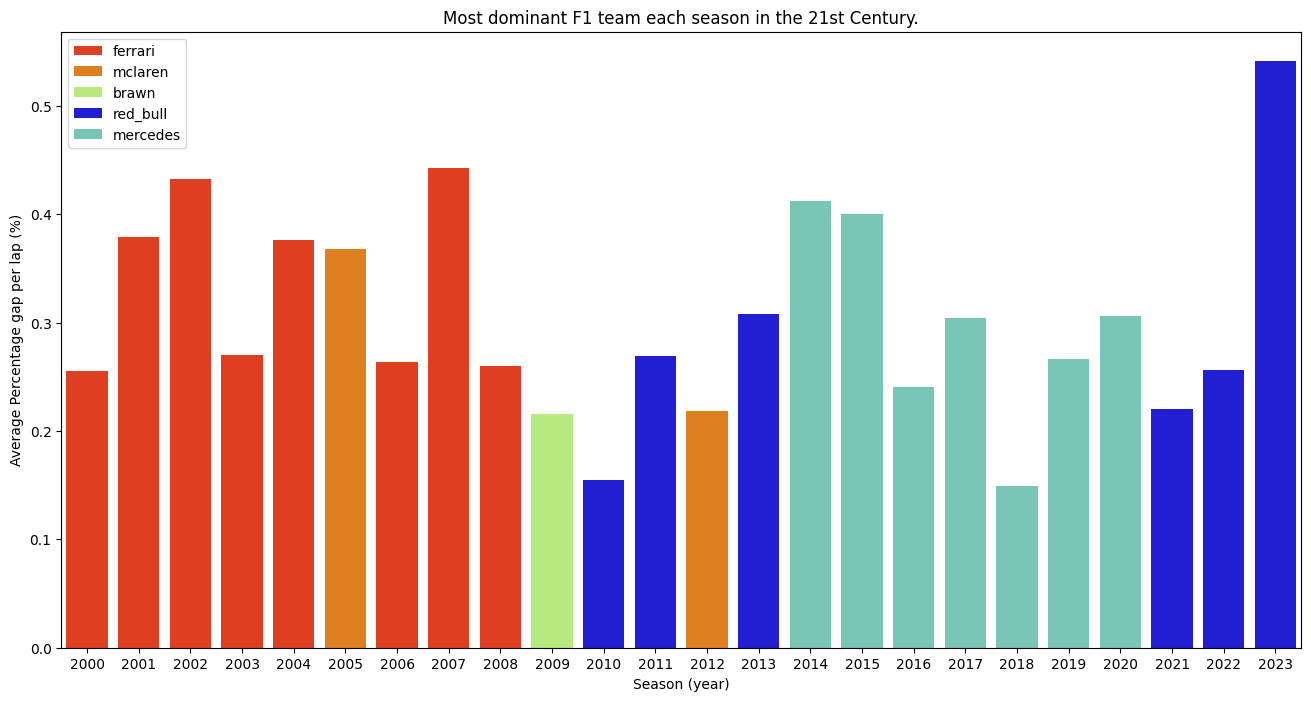

In [24]:
plt.figure(figsize=(16, 8))
sns.barplot(x='year', y='gap_percent', data=avg_gap_per_year, hue='fastest_team', palette=colours, width=0.8, dodge=False)

plt.xlabel('Season (year)')
plt.ylabel('Average Percentage gap per lap (%)')
plt.title('Most dominant F1 team each season in the 21st Century.')
plt.legend(loc='upper left')
plt.show()